In [1]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


## Learning results

In [2]:
import os
import json
import pandas as pd

# Define the directory name
exp_name = "split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833"
directory = f"experiments/{exp_name}/results"

# Load the JSON file
with open(os.path.join(directory, "experiments.json"), "r") as file:
    data = json.load(file)

# Extract the "config" dictionary and save it into a pandas dataframe
config_df = pd.DataFrame([data[0]["config"]])

# Add the "end_results" dictionary to the dataframe
end_results = data[0]["end_results"]
for key, value in end_results.items():
    config_df[key] = value

# Load the "transfer" dictionary
transfer_dict = data[0]["transfer"]

print(config_df)
print(transfer_dict)

    network optimizer    lr  weight_decay  momentum  step_scheduler_decay  \
0  resnet18       SGD  0.05       0.00001       0.9                   300   

   cosine_scheduler_duration  scheduler_step scheduler_type loss  ...  \
0                        1.0             0.1  cosine_anneal   CE  ...   

                 environment  agent_type num_classes_per_task  \
0  split-cifar100-classes-10        base                   10   

  num_classes_total multihead  experiment_duration device        date  \
0               100      True                10000      0  2025-03-14   

  test_loss_end test_error_end  
0      0.648711       0.205469  

[1 rows x 29 columns]
{'0': {'0': {'test_loss': 0.9937456250190735, 'test_error': 0.2890625, 'task_name': 'split_classes_10_0'}, '1': {'test_loss': 2.32216739654541, 'test_error': 0.8843749985098839, 'task_name': 'split_classes_10_1'}, '2': {'test_loss': 2.3229358196258545, 'test_error': 0.8640625029802322, 'task_name': 'split_classes_10_2'}, '3': {'t

In [3]:
config_df.columns

Index(['network', 'optimizer', 'lr', 'weight_decay', 'momentum',
       'step_scheduler_decay', 'cosine_scheduler_duration', 'scheduler_step',
       'scheduler_type', 'loss', 'batch_size', 'warmup_on', 'exp_id',
       'exp_timestamp', 'exp_name', 'seed', 'steps_per_task', 'num_tasks',
       'ordering', 'environment', 'agent_type', 'num_classes_per_task',
       'num_classes_total', 'multihead', 'experiment_duration', 'device',
       'date', 'test_loss_end', 'test_error_end'],
      dtype='object')

In [4]:
import numpy as np

# Initialize the matrix
num_tasks = len(transfer_dict)
matrix = np.zeros((num_tasks, num_tasks))

# Populate the matrix
for i in range(num_tasks):
    for j in range(num_tasks):
        matrix[i, j] = transfer_dict[str(i)][str(j)]['test_error']

print(matrix)

[[0.2890625  0.884375   0.8640625  0.80624999 0.9125     0.9109375
  0.8921875  0.87343749 0.909375   0.890625  ]
 [0.24531251 0.34375    0.82656249 0.828125   0.9171875  0.9125
  0.8046875  0.859375   0.9140625  0.8625    ]
 [0.22187501 0.30312496 0.26406246 0.84218749 0.884375   0.9109375
  0.84218749 0.84531249 0.934375   0.859375  ]
 [0.25624996 0.26406246 0.22031248 0.2890625  0.8796875  0.9265625
  0.8359375  0.875      0.9109375  0.8484375 ]
 [0.24531251 0.25468749 0.25156248 0.27499998 0.22812498 0.9390625
  0.85781249 0.86874999 0.925      0.85781249]
 [0.20625001 0.25156248 0.22499996 0.25624996 0.22499996 0.23281246
  0.8484375  0.875      0.9328125  0.875     ]
 [0.2421875  0.26249999 0.23124999 0.25937498 0.21718746 0.25156248
  0.2421875  0.884375   0.93125    0.8921875 ]
 [0.22968751 0.2421875  0.2265625  0.24843746 0.22187501 0.24531251
  0.23750001 0.24531251 0.9390625  0.875     ]
 [0.21249998 0.2265625  0.21875    0.26093751 0.22031248 0.21406251
  0.203125   0.21406

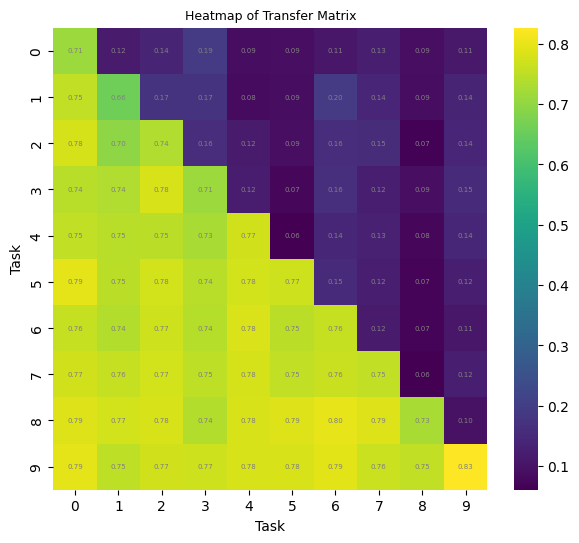

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set annotation font size and color
annot_kws = {"size": 5, "color": "gray"}

# Plot the heatmap
plt.figure(figsize=(7, 6), dpi=100)
sns.heatmap(1 - matrix, annot=True, fmt=".2f", cmap="viridis", annot_kws=annot_kws)
plt.title("Heatmap of Transfer Matrix", fontsize=9)
plt.xlabel("Task")
plt.ylabel("Task")
plt.show()

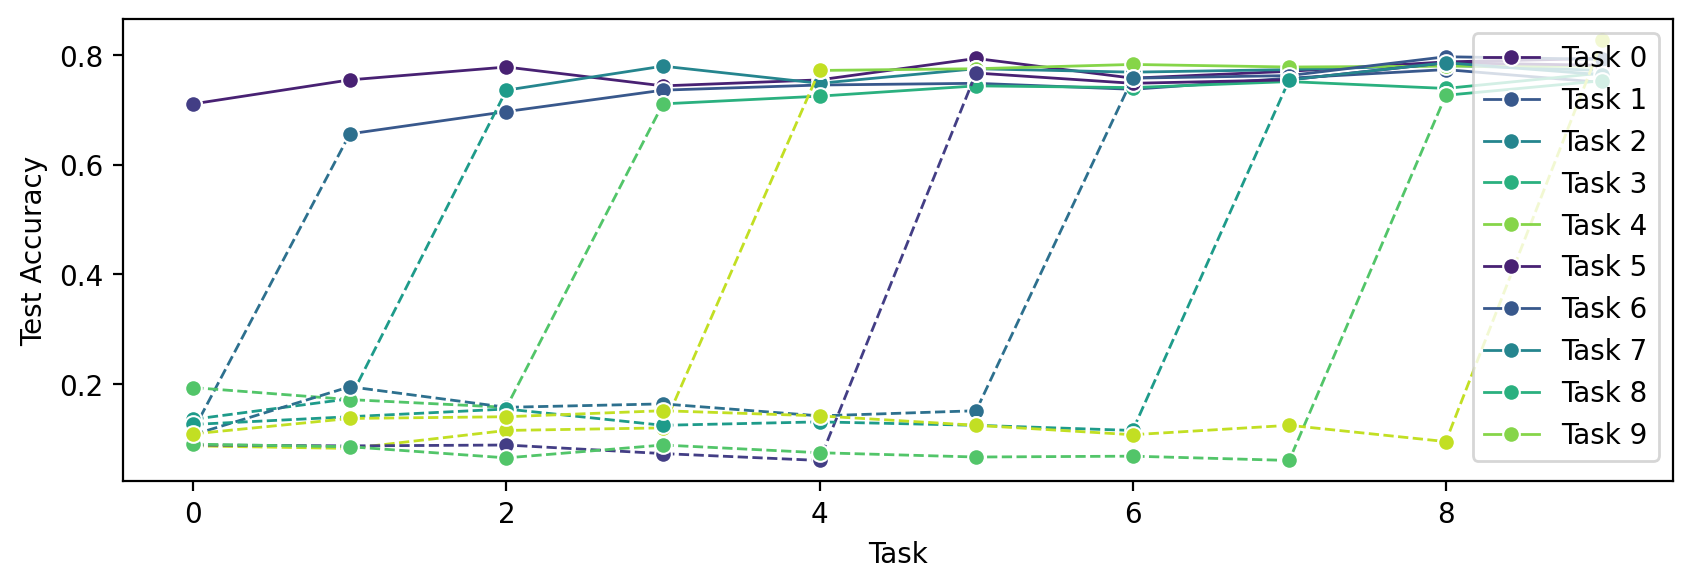

In [6]:
# Create a line plot for each row in the transfer matrix using seaborn
plt.figure(figsize=(10, 3), dpi=200)
palette = sns.color_palette("viridis", num_tasks)
sns.set_palette(palette)
for i in range(num_tasks):
    sns.lineplot(x=range(num_tasks)[i:], y=1-matrix[i:,i], label=f'Task {i}', linewidth=1, marker='o', markersize=6)
    sns.lineplot(x=range(num_tasks)[:i+1], y=1-matrix[:i+1,i], linestyle="--", linewidth=1, marker='o', markersize=6, label=None)
plt.xlabel('Task')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

## Parameter space investigation

In [7]:
from agents import get_agent_class_from_name
from utils import *
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataloader import DataLoader
from environments import get_environment_from_name

from hyperparameters import agent_hyperparameters

import importlib


/media/hofmann-scratch/glanzillo/projects_mixed/clenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import environments, agents
importlib.reload(environments)
importlib.reload(agents)
from environments import get_environment_from_name
from agents import get_agent_class_from_name

In [9]:
from evaluation import evaluate_agent_task

### Loading everything we need

In [10]:
acf = dotdict(config_df.iloc[0])
acf

{'network': 'resnet18',
 'optimizer': 'SGD',
 'lr': np.float64(0.05),
 'weight_decay': np.float64(1e-05),
 'momentum': np.float64(0.9),
 'step_scheduler_decay': np.int64(300),
 'cosine_scheduler_duration': np.float64(1.0),
 'scheduler_step': np.float64(0.1),
 'scheduler_type': 'cosine_anneal',
 'loss': 'CE',
 'batch_size': np.int64(50),
 'warmup_on': np.True_,
 'exp_id': 'exp1',
 'exp_timestamp': '20250314_121833',
 'exp_name': 'split-c100-classes-10_resnet18_base_multihead',
 'seed': np.int64(95),
 'steps_per_task': [1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000],
 'num_tasks': np.int64(10),
 'ordering': ['split_classes_10_0',
  'split_classes_10_1',
  'split_classes_10_2',
  'split_classes_10_3',
  'split_classes_10_4',
  'split_classes_10_5',
  'split_classes_10_6',
  'split_classes_10_7',
  'split_classes_10_8',
  'split_classes_10_9'],
 'environment': 'split-cifar100-classes-10',
 'agent_type': 'base',
 'num_classes_per_task': np.int64(10),
 'num_cla

In [11]:
# Set random seed for reproducibility
seed = acf.seed; print(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

95


In [12]:
device = 2

acf.device = device
agent_class = get_agent_class_from_name(acf.agent_type)
agent = agent_class(**acf)
agent_config = agent.config # collect the filled config (with all the agent- and experiment-related info)

Dynamic output mode.
Number of parameters 11.220132 MLN
Setup complete.


In [13]:
experiment_logger = ExperimentLogger(agent_config["exp_id"], agent_config["exp_timestamp"], agent_config["exp_name"], config=agent_config)

INFO:root:Training Configuration -base Agent: {'network': 'resnet18', 'optimizer': 'SGD', 'lr': np.float64(0.05), 'weight_decay': np.float64(1e-05), 'momentum': np.float64(0.9), 'step_scheduler_decay': np.int64(300), 'cosine_scheduler_duration': np.float64(1.0), 'scheduler_step': np.float64(0.1), 'scheduler_type': 'cosine_anneal', 'loss': 'CE', 'batch_size': np.int64(50), 'warmup_on': np.True_, 'exp_id': 'exp1', 'exp_timestamp': '20250314_121833', 'exp_name': 'split-c100-classes-10_resnet18_base_multihead', 'seed': np.int64(95), 'steps_per_task': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'num_tasks': np.int64(10), 'ordering': ['split_classes_10_0', 'split_classes_10_1', 'split_classes_10_2', 'split_classes_10_3', 'split_classes_10_4', 'split_classes_10_5', 'split_classes_10_6', 'split_classes_10_7', 'split_classes_10_8', 'split_classes_10_9'], 'environment': 'split-cifar100-classes-10', 'agent_type': 'base', 'num_classes_per_task': np.int64(10), 'num_classes_total':

In [14]:
acf.environment
acf.split_type = "classes"
acf.number_tasks = acf.num_tasks

In [15]:
env, environment_name = get_environment_from_name("split", acf)

In [16]:
# labels = set()
# for x,y,t in DataLoader(env.environment['train']['split_classes_10_9']): 
#     labels.add(y.item())
# labels

# env.ordered_task_names


In [17]:
batches_eval = env.batches_eval
eval_criterion = env.criterion
num_classes_per_task = env.num_classes_per_task 
num_classes_total = env.num_classes

In [18]:
def get_multitask_dataloaders(env, task_id, batch_size): 
    # initializing task objective and training data iterator
    train_data = env.init_multi_task(number_of_tasks=task_id+1, train=True)
    train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

    # initialize training-time evaluation data 
    test_data = env.init_multi_task(number_of_tasks=task_id+1, train=False) # same test data for both agents
    test_data_loader = DataLoader(test_data, batch_size=128, shuffle=True, num_workers=4)

    return train_data_loader, test_data_loader

def get_singletask_dataloaders(env, task_id, batch_size): 
    # initializing task objective and training data iterator
    train_data = env.init_single_task(task_number=task_id, train=True)
    train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

    # initialize training-time evaluation data 
    test_data = env.init_single_task(task_number=task_id, train=False)
    test_data_loader = DataLoader(test_data, batch_size=128, shuffle=True, num_workers=4)

    return train_data_loader, test_data_loader

Take parameters from network

In [19]:
def get_params(net):
    # Initialize an empty list to store the parameters
    params_list = []

    # Iterate over all the parameters of the network and append them to the list
    for param in net.parameters():
        params_list.append(param.data.view(-1))

    # Concatenate the list to a single tensor
    params_vector = torch.cat(params_list)

    return params_vector

# Use the function to get parameters of the agent's network
params_vector = get_params(agent.network)
print(params_vector)

tensor([ 0.0284, -0.1382,  0.1217,  ..., -0.0428,  0.0073, -0.0287],
       device='cuda:2')


Load checkpoint

In [20]:
experiment_logger.load_checkpoint(agent, 9)

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t9-s1000.pth
2025-03-14 16:07:01,075 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t9-s1000.pth


In [21]:
def evaluate_checkpoint(ckpt_task, data_task, agent, logger, env, train=False): 
    agent = logger.load_checkpoint(agent, ckpt_task) # after first task
    agent.config['device'] = device
    train_dataloader, test_dataloader = get_singletask_dataloaders(env, data_task, 128)
    dataloader = train_dataloader if train else test_dataloader
    eval = evaluate_agent_task(5, agent, iter(dataloader), eval_criterion, -1)
    return eval

In [22]:
evaluate_checkpoint(0, 0, agent, experiment_logger, env,train=False)

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t0-s1000.pth
2025-03-14 16:07:02,245 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t0-s1000.pth


{'test_loss': 1.068804144859314, 'test_error': 0.30000001192092896}

### Distance measures

Basic distance measures

In [19]:

def get_norm_distance(m1, m2):
    return torch.norm(m1-m2, 2).item()


def get_cosine_similarity(m1, m2):
    cosine = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
    return cosine(m1, m2)

In [168]:
experiment_logger.load_checkpoint(agent, 1) # after first task
m1 = get_params(agent.network)
experiment_logger.load_checkpoint(agent, 10) # after last task 
m10 = get_params(agent.network)

get_norm_distance(m1, m10), get_cosine_similarity(m1, m10)

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t1-s9990.pth
2025-03-13 17:49:18,059 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t1-s9990.pth
2025-03-13 17:49:18,059 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t1-s9990.pth
INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t10-s99990.pth
2025-03-13 17:49:23,380 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t10-s99990.pth
2025-03-13 17:49:23,380 - Loading model checkpoint from ./experiments/split-c1

(82.62105560302734, tensor(0.7088))

In [169]:
# Initialize the distance matrices
l2_distance = np.zeros((num_tasks+1, num_tasks+1))
cosine_distance = np.zeros((num_tasks+1, num_tasks+1))

minima = []
for i in range(num_tasks+1):
    experiment_logger.load_checkpoint(agent, i)
    minima.append(get_params(agent.network))

# Populate the l2_distance matrix
for i in range(num_tasks+1):
    mi = minima[i]
    for j in range(num_tasks+1):
        mj = minima[j]
        l2_distance[i, j] = get_norm_distance(mi, mj)
        cosine_distance[i, j] = get_cosine_similarity(mi, mj)

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t0-s0.pth
2025-03-13 17:49:25,606 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t0-s0.pth
2025-03-13 17:49:25,606 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t0-s0.pth
INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t1-s9990.pth
2025-03-13 17:49:27,194 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t1-s9990.pth
2025-03-13 17:49:27,194 - Loading model checkpoint from ./experiments/split-c100-classes-10

In [170]:
l2_distance

array([[ 0.        , 38.75257111, 52.69868469, 61.49184036, 68.12860107,
        74.0770874 , 79.00593567, 83.02571869, 87.79180145, 93.03648376,
        95.7852478 ],
       [38.75257111,  0.        , 30.08229446, 41.48345947, 49.86280441,
        57.15524292, 63.08921051, 67.94907379, 73.40019226, 79.33825684,
        82.6210556 ],
       [52.69868469, 30.08229446,  0.        , 26.08481026, 36.88938141,
        45.59009933, 52.44410706, 58.02901459, 64.13442993, 70.61365509,
        74.27848816],
       [61.49184036, 41.48345947, 26.08481026,  0.        , 25.06336594,
        35.89049911, 43.88922501, 50.21161652, 56.92716217, 63.95346451,
        67.96327209],
       [68.12860107, 49.86280441, 36.88938141, 25.06336594,  0.        ,
        24.76696014, 34.79932404, 42.1723175 , 49.70173645, 57.34909439,
        61.71652222],
       [74.0770874 , 57.15524292, 45.59009933, 35.89049911, 24.76696014,
         0.        , 24.16851616, 33.57855988, 42.37353134, 50.83686066,
        55.598

Text(0.5, 1.0, 'L2 distance')

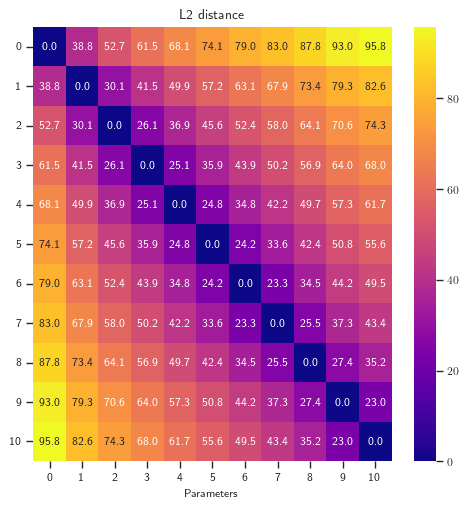

In [171]:


import matplotlib

matrix = l2_distance
labels = range(num_tasks+1)


plt.figure(figsize=(5, 5), dpi=100)

sns.set(style="ticks")
sns.set_context("paper",rc={"lines.linewidth": 2.5,
                'xtick.labelsize':8,
                'ytick.labelsize':8,
                'lines.markersize' : 8,
                'legend.fontsize': 8,
                'axes.labelsize': 8,
                'legend.handlelength': 1,
                'legend.handleheight':1,})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

ax = sns.heatmap(matrix, annot=True, fmt='.1f', cbar=True, \
    xticklabels=labels, yticklabels=labels,\
    annot_kws={'size': 8}, cmap='plasma')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
plt.xlabel(r'Parameters')
plt.tight_layout()
plt.title("L2 distance")
# ax.get_figure().savefig(path+'.png', dpi=200)
# ax.get_figure().savefig(path+'.pdf', dpi=200)
# plt.close()

Text(0.5, 1.0, 'Cosine distance')

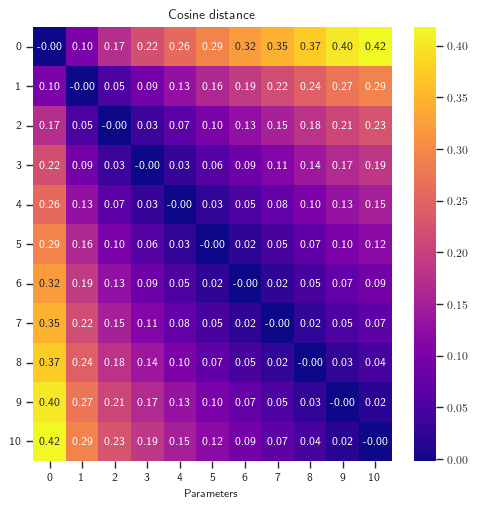

In [172]:


import matplotlib

matrix = 1 - cosine_distance
labels = range(num_tasks+1)


plt.figure(figsize=(5, 5), dpi=100)

sns.set(style="ticks")
sns.set_context("paper",rc={"lines.linewidth": 2.5,
                'xtick.labelsize':8,
                'ytick.labelsize':8,
                'lines.markersize' : 8,
                'legend.fontsize': 8,
                'axes.labelsize': 8,
                'legend.handlelength': 1,
                'legend.handleheight':1,})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

ax = sns.heatmap(matrix, annot=True, fmt='.2f', cbar=True, \
    xticklabels=labels, yticklabels=labels,\
    annot_kws={'size': 8}, cmap='plasma')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
plt.xlabel(r'Parameters')
plt.tight_layout()
plt.title("Cosine distance")
# ax.get_figure().savefig(path+'.png', dpi=200)
# ax.get_figure().savefig(path+'.pdf', dpi=200)
# plt.close()

CKA distance

### Linear Mode Connectivity

In [94]:
def reset_batchnorm(module):
    if isinstance(module, torch.nn.BatchNorm2d):  
        module.running_mean = torch.zeros_like(module.running_mean)
        module.running_var = torch.ones_like(module.running_var)
    
def interpolate_batchnorm(module, name, start_stats, end_stats, t):
    if name in start_stats['mean'].keys() and name in end_stats['mean'].keys():
        module.running_mean = (1 - t) * start_stats['mean'][name] + t * end_stats['mean'][name]
        module.running_var = (1 - t) * start_stats['var'][name] + t * end_stats['var'][name]
        print(module.running_mean)
        

In [95]:
def has_batch_norm(net):
    for n, p in net.named_modules():
        if isinstance(p, torch.nn.BatchNorm2d): return True
    return False

In [105]:
from tqdm import tqdm


def linear_interpolation(start, end, agent, dataloader, line_samples=10, tasks_learned=-1, batches=10, return_type="loss"): 
    loss = [] 
    line_range = np.arange(0.0, 1.01, 1.0/float(line_samples))

  
    direction = end - start
    print(direction.max())
    
    for t in tqdm(line_range, desc="Interpolating"):
        cur_weight = start + (direction * t)
        agent.network.assign_weights(cur_weight.to(device))
        agent.config['device'] = device
        if has_batch_norm(agent.network): 
            torch.optim.swa_utils.update_bn(iter(dataloader), agent.network, device)
            
        current_loss = evaluate_agent_task(batches, agent, iter(dataloader), eval_criterion, tasks_learned)[f'test_{return_type}']
        loss.append(current_loss)
    return loss, line_range

In [103]:
def plot_single_interpolation(x, y, measure="Validation", label=""):
    plt.figure(figsize=(5, 3), dpi=200)
    sns.set(style="whitegrid")
    sns.set_context("paper",rc={"lines.linewidth": 2,
                    'xtick.labelsize':8,
                    'ytick.labelsize':8,
                    'lines.markersize' : 100,
                    'lines.markers' : 'o',
                    'legend.fontsize': 8,
                    'axes.labelsize': 8,
                    'legend.handlelength': 1,
                    'legend.handleheight':1,})

    color = 'orange'
    suffix = 'loss'
    sns.lineplot(x=x, y=y, color=color, label=label)
    plt.xlabel('Interpolation')
    plt.ylabel('{} {}'.format(measure, suffix))
    # plt.title(title)
    # plt.ylim((0.0, 0.005))
    plt.tight_layout()
    plt.show()

In [106]:
agent = experiment_logger.load_checkpoint(agent, 0) # after first task
start = get_params(agent.network).to(device).clone()

agent = experiment_logger.load_checkpoint(agent, 1) # after first task
end = get_params(agent.network).to(device).clone()

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t0-s1000.pth
2025-03-14 16:57:51,783 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t0-s1000.pth
INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t1-s1000.pth
2025-03-14 16:57:51,909 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t1-s1000.pth


tensor(0.3542, device='cuda:2')


Interpolating: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


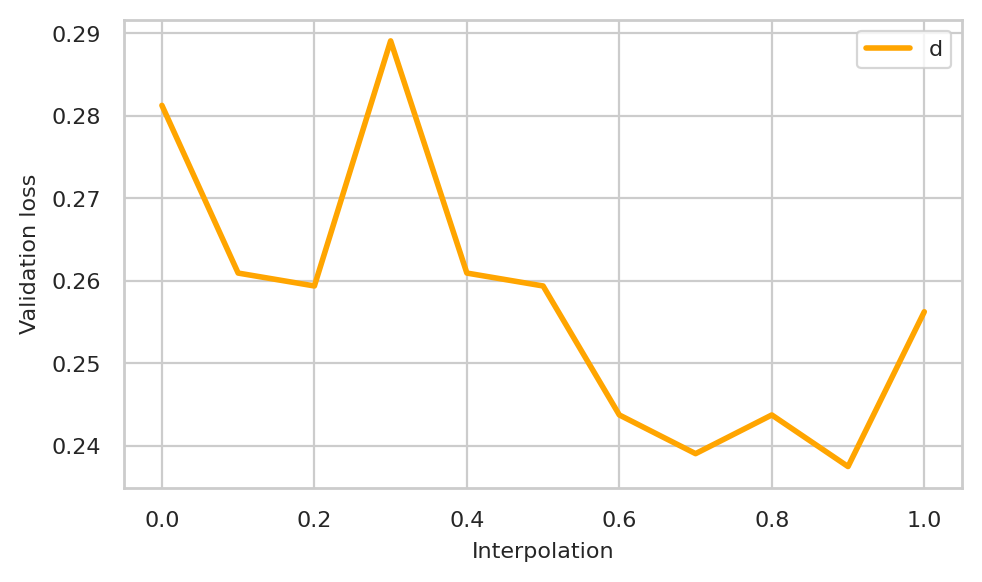

In [107]:
# linear mode connectivity on loss of task 1 between task 1 and task 2 solutions

train_dataloader, test_dataloader = get_singletask_dataloaders(env, 0, 128)

# # train data
# l_values, x_values = linear_interpolation(m1, m2, agent, train_dataloader, line_samples=10, tasks_learned=-1, batches=5, return_type="error")
# plot_single_interpolation(x_values, l_values, measure="Training", label="d")

# test data 
l_values, x_values = linear_interpolation(start, end, agent, test_dataloader, line_samples=10, tasks_learned=-1, batches=5, return_type="error")
plot_single_interpolation(x_values, l_values, measure="Validation", label="d")

From 1 to all the others

In [109]:
minima = []
for i in range(num_tasks+1):
    experiment_logger.load_checkpoint(agent, i)
    minima.append(get_params(agent.network).to(device))
agent.config['device']=device

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t0-s1000.pth
2025-03-14 16:58:36,127 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t0-s1000.pth
INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t1-s1000.pth
2025-03-14 16:58:36,252 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t1-s1000.pth
INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t2-s1000.pth
2025-03-14 16:58:36,320 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t2-s1000.pth
INFO:root:Loading model checkpoint from 

In [111]:
train_dataloader, test_dataloader = get_singletask_dataloaders(env, 0, 128)
# Initialize the loss matrix
line_samples=10
l_values_all = np.zeros((num_tasks, line_samples+1))

# Populate the loss matrix
m1 = minima[1]
for i in range(num_tasks):
    mi = minima[i]
    l_values, x_values = linear_interpolation(m1, mi, agent, test_dataloader, line_samples=line_samples, tasks_learned=-1, batches=5)
    l_values_all[i,:] = l_values

tensor(0.3349, device='cuda:2')


Interpolating: 100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


tensor(0., device='cuda:2')


Interpolating: 100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


tensor(0.4053, device='cuda:2')


Interpolating: 100%|██████████| 11/11 [00:19<00:00,  1.73s/it]


tensor(0.5415, device='cuda:2')


Interpolating: 100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


tensor(0.7283, device='cuda:2')


Interpolating: 100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


tensor(0.8615, device='cuda:2')


Interpolating: 100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


tensor(0.9677, device='cuda:2')


Interpolating: 100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


tensor(1.0077, device='cuda:2')


Interpolating: 100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


tensor(1.0857, device='cuda:2')


Interpolating: 100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


tensor(1.1755, device='cuda:2')


Interpolating: 100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


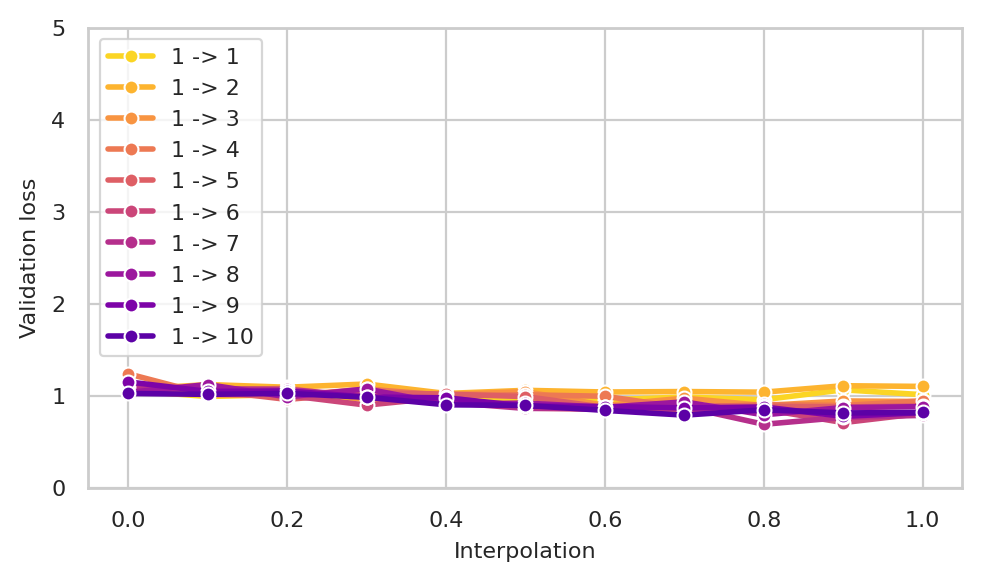

In [115]:
plt.figure(figsize=(5, 3), dpi=200)
sns.set(style="whitegrid")
sns.set_context("paper",
                rc={"lines.linewidth": 2,
                'xtick.labelsize':8,
                'ytick.labelsize':8,
                'lines.markersize' : 5,
                'lines.marker' : 'o',
                'legend.fontsize': 8,
                'axes.labelsize': 8,
                'legend.handlelength': 1,
                'legend.handleheight':1,})

palette = sns.color_palette("plasma_r", num_tasks+1)
suffix = 'loss'
for i in range(num_tasks): 
    sns.lineplot(x=x_values, y=l_values_all[i,:], color=palette[i], label=f"1 -> {i+1}", marker='o')
plt.xlabel('Interpolation')
plt.ylabel('Validation {}'.format(suffix))
# plt.title(title)
plt.ylim((0.0, 5))
plt.tight_layout()
plt.legend(loc='upper left', fontsize='small')
plt.show()

## Hessian and 2nd order approximations